# Digit Recognizer Dataset Introduction
###It contains the following info:
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

In [ ]:
import os

local_assets_b = False

if local_assets_b:
  assets_dir = "/content/assets/P2/"

  if not os.path.isdir(assets_dir):
    assert os.path.isfile("assets.zip")
    os.system("unzip assets.zip")
else:
  from google.colab import drive
  drive.mount('/content/drive')
  assets_dir = '/content/drive/MyDrive/NeuralNetwork_IK/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch                        # The core package of Torch
import torch.nn as nn               # The nn package is used for building neural networks
import torch.nn.functional as F     # Contains all the functions in the torch.nn library

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

###Load data
As input information I have two CSV files:

####**train.csv** - contains information about 42 000 (60% of the whole MNIST dataset) gray-scale images of hand-drawn digits (from 0 to 9).
First column is the digit. The rest 784 columns represent pixels of hand-drawn digit (each image has 28 x 28 pixels shape). The value of each pixel-column is an intager between 0 and 255 - represent darkness or lightness of the given pixel.
####**test.csv** - contains information about 28 000 gray-scale images of hand-drawn digits (from 0 to 9). Doesn't contain labels.

In [ ]:
# read data
train_data = pd.read_csv('/content/drive/MyDrive/NeuralNetwork_IK/Digit_Recognizer_Dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/NeuralNetwork_IK/Digit_Recognizer_Dataset/test.csv')

# check that we loaded data correctly
print("Train data shape:", train_data.shape)
print("Test data shape:", test.shape)

Train data shape: (42000, 785)
Test data shape: (28000, 784)


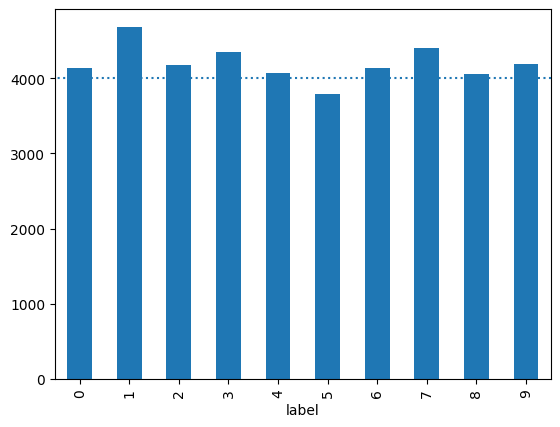

In [ ]:
label_counts  = train_data["label"].value_counts().sort_index()
label_counts.plot.bar()
plt.hlines(xmin = -1, xmax = 10, y = 4000, linestyles='dotted')


Split labels and features of training dataset and convert to numpy array:

In [ ]:
train_all = train_data.iloc[:,1:]     # only features (pixels)
train_all_label = train_data["label"] # labels

# convert to numpy array
train_all_numpy = train_all.to_numpy()
train_all_label_numpy = train_all_label.to_numpy()
test_numpy = test.to_numpy()

visualize some train examples with it's labels:

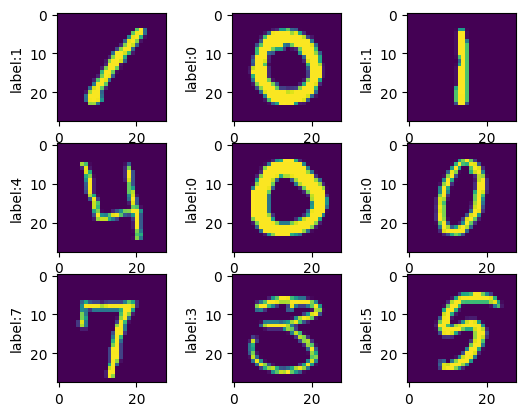

In [ ]:
def plot_img(data, label):
    fig, axs = plt.subplots(3, 3) # 9 images
    k = 0
    for i in range(3):
        for j in range(3):
            axs[i, j].imshow(data[k].astype('uint8').reshape(28, 28))   # plot image
            axs[i, j].set_ylabel("label:" + str(label[k].item()))       # print label
            k +=1
plot_img(train_all_numpy, train_all_label_numpy)

###Train and validation
check model on unseen data before submitting it.
Since we don't have labels in test dataset, we will randomly split my training data on training and validation datasets in proportion 8:2.
To do so, we will be using train_test_split function from sklearn module:

In [ ]:
# split train on train and validation
train, validation, train_label, validation_label = train_test_split(train_all_numpy, train_all_label_numpy, test_size=0.2)

print(train.shape)
print(train_label.shape)
print(validation.shape)
print(validation_label.shape)

(33600, 784)
(33600,)
(8400, 784)
(8400,)


Check if both datasets represent all classes in fair proportion:

<BarContainer object of 10 artists>

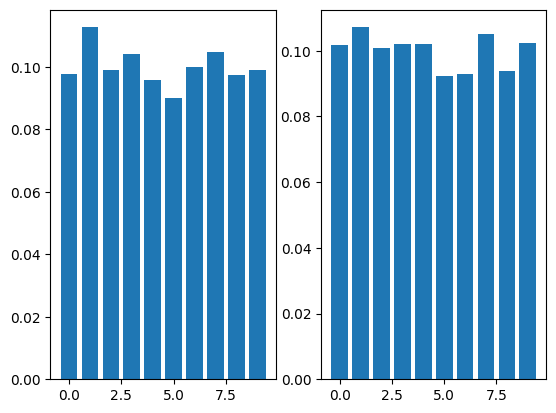

In [ ]:
unique, counts_train = np.unique(train_label, return_counts=True)
plt.subplot(1, 2, 1)
plt.bar(unique, counts_train/len(train_label))
unique, counts_val = np.unique(validation_label, return_counts=True)
plt.subplot(1, 2, 2)
plt.bar(unique, counts_val/len(validation_label))
#print (np.asarray((unique, counts_train/len(train_label), counts_val/len(validation_label))).T)

###Tensors
Tensor is a multi-dimensional matrix containing elements of a single data type. To use PyTorch, we need to covert our data to tensors.

In [ ]:
train_all_tensor = torch.as_tensor(train_all_numpy).type(torch.FloatTensor)
train_all_label_tensor = torch.as_tensor(train_all_label_numpy)
test_tensor = torch.as_tensor(test_numpy).type(torch.FloatTensor)

train_tensor = torch.as_tensor(train).type(torch.FloatTensor)
train_label = torch.as_tensor(train_label)

validation_tensor = torch.as_tensor(validation).type(torch.FloatTensor)
validation_label = torch.as_tensor(validation_label)

###FNN
Let's build the model

In [ ]:
                   # nn.Module - Base class for all neural network modules.
class FNet(nn.Module):
    def __init__(self):
        super(FNet, self).__init__()
                   # 784 inputs, connects to hidden layer with 600 nodes
        self.fc1 = nn.Linear(in_features=784, out_features=600)
                   # 600 nodes connects to hidden layer with 500 nodes
        self.fc2 = nn.Linear(in_features=600, out_features=500)
                   # 500 nodes connects to hidden layer with 250 nodes
        self.fc3 = nn.Linear(in_features=500, out_features=250)
                   # connection between the last hidden layer
                   # and the output layer (with 10 nodes)
        self.fc4 = nn.Linear(in_features=250, out_features=10)

    def forward(self, x):
        x = x.view(-1,784)          # Put all the entries of the image in the vector
        x = F.relu(self.fc1(x))     # Input x into first layer and apply a ReLU
                                    # to the nodes in this layer
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

###Layers
A fully connected neural network consists of a series of fully connected layers.
The first layer takes the 784 (28 x 28) input pixels and connects to the first 600 node hidden layer. Then we have 600 to 500 hidden layer, 500 to 250 hidden layer and in the end the connection between the last hidden layer and the output layer (with 10 nodes).

input: 784 (image shape)
3 hidden layers (600, 500, 250 nodes)
output: 10 neurons for each possible class
I use nn.Linear to constructs a fully connected layer. The first argument is the number of nodes in layer l and the next argument is the number of nodes in layer l+1.

###Forward method
First, I need to reshape tensor x, so I use the view function for it.
Second, input data x into the first fully connected layer (self.fc1(x)) and then apply a ReLU activation to the nodes in this layer using. Because of the hierarchical nature of this network, we replace x at each stage, feeding it into the next layer.
We do this through our three fully connected layers, except for the last one.
As activation function, I am using ReLU (The Rectified Linear Unit). It gives an output 0 if x is negative and x otherwise. The purpose of the activation function is to introduce non-linearity into the network (non-linear means that the output can not be reproduced from a linear combination of the inputs). To do it in code, I am using F.relu - applies the rectified linear unit function element-wise.



###Accuracy
Before start the training process, let's define an accuracy function.
#####Accuracy - fraction of the time classifier is correct.

In [ ]:
def get_accuracy(predictions, true_labels):
    _, predicted = torch.max(predictions, 1)
    corrects = (predicted == true_labels).sum()
    accuracy = 100.0 * corrects/len(true_labels)
    return accuracy.item()

###Training function
###Training process:

1.   Do a forward pass
2.   Calculate loss function
3.   Calculate the gradients
4.   Change the weights based on gradients

The entire training of the network is based on minimizing the loss function. An optimizer determines, based on the loss function, how each parameter should change.
The optimizer solves the credit assignment problem: how do we assign credit to the parameters when the network performs poorly?

In [ ]:
def training (dataloader, epochs, model, criterion, optimizer):

    train_accuracies, train_losses = [], []

    # set the train mode
    model.train()

    # loop over training dataset multiple times
    for epoch in range(epochs):

        train_loss = 0
        train_accuracy = 0
        num_batch = 0

        # iterate over all batches
        for data, labels in dataloader:

            # zero the parameters gradient to not accumulate gradients from previous iteration
            optimizer.zero_grad()

            # put data into the model
            predictions = net(data)

            # calculate loss
            loss = criterion(predictions, labels)

            # calculate accuracy
            accuracy = get_accuracy(predictions, labels)

            # compute gradients
            loss.backward()

            # change the weights
            optimizer.step()

            num_batch += 1
            train_loss += loss.item()
            train_accuracy += accuracy

        epoch_accuracy = train_accuracy/num_batch
        epoch_loss = train_loss/num_batch
        train_accuracies.append(epoch_accuracy)
        train_losses.append(epoch_loss)

        print("Epoch: {}/{} ".format(epoch + 1, epochs),
              "Training Loss: {:.4f} ".format(epoch_loss),
              "Training accuracy: {:.4f}".format(epoch_accuracy))

    return train_accuracies, train_losses

In [ ]:
torch.manual_seed(0)                                      # set seed to make results reproducible

batch_size = 128                                          # Set the batch_size
train_dataset = torch.utils.data.TensorDataset(train_tensor, train_label)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)


epochs = 40                                               # set number of epohs

net = FNet()                                              # initialize network
criterion = nn.CrossEntropyLoss()                         # set criterion
optimizer = torch.optim.Adam(net.parameters(), lr = 3e-4) # set optimizer

                                                          # start training process
train_accuracies, train_losses = training(trainloader, epochs, net, criterion, optimizer)

Epoch: 1/40  Training Loss: 0.2921  Training accuracy: 91.6261
Epoch: 2/40  Training Loss: 0.0957  Training accuracy: 97.0057
Epoch: 3/40  Training Loss: 0.0508  Training accuracy: 98.3811
Epoch: 4/40  Training Loss: 0.0347  Training accuracy: 98.9039
Epoch: 5/40  Training Loss: 0.0290  Training accuracy: 99.0197
Epoch: 6/40  Training Loss: 0.0267  Training accuracy: 99.0702
Epoch: 7/40  Training Loss: 0.0278  Training accuracy: 99.0880
Epoch: 8/40  Training Loss: 0.0293  Training accuracy: 99.0583
Epoch: 9/40  Training Loss: 0.0155  Training accuracy: 99.4742
Epoch: 10/40  Training Loss: 0.0176  Training accuracy: 99.4089
Epoch: 11/40  Training Loss: 0.0218  Training accuracy: 99.3465
Epoch: 12/40  Training Loss: 0.0234  Training accuracy: 99.2663
Epoch: 13/40  Training Loss: 0.0197  Training accuracy: 99.4089
Epoch: 14/40  Training Loss: 0.0148  Training accuracy: 99.5604
Epoch: 15/40  Training Loss: 0.0137  Training accuracy: 99.5752
Epoch: 16/40  Training Loss: 0.0226  Training acc

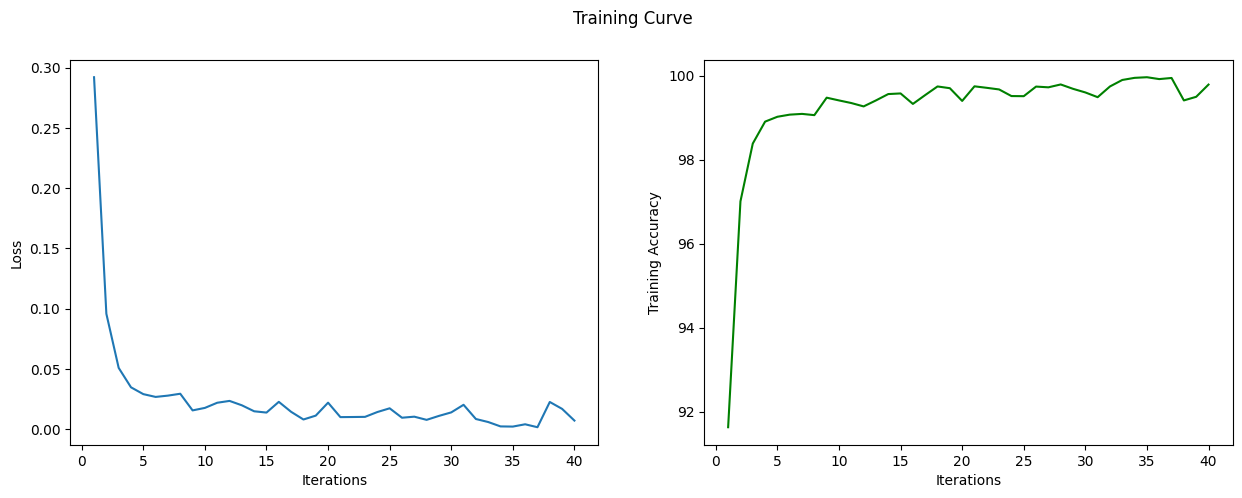

In [ ]:
def train_curves(epochs, train_losses, train_accuracies):
    iters = range(1, epochs+1)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
    fig.suptitle('Training Curve')
    ax1.plot(iters, train_losses)
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax2.plot(iters, train_accuracies, color = 'g')
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Training Accuracy")
    plt.show()

train_curves(epochs, train_losses, train_accuracies)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# set net in test (evaluation) mode
net.eval()
# get predictions
val_predictions = net(validation_tensor)
val_loss = criterion(val_predictions, validation_label)
val_accurasy = get_accuracy(val_predictions, validation_label)

print("Loss: ", str(val_loss.item()), "Accuracy: ", str(val_accurasy))

# to get class with the maximum score as prediction
_, val_predicted = torch.max(val_predictions.data,1)

# confusion matrix
confusion_matrix(validation_label, val_predicted)

Loss:  0.14891868829727173 Accuracy:  97.79762268066406


array([[864,   0,   0,   0,   1,   3,   6,   2,   2,   0],
       [  0, 912,   0,   1,   1,   0,   2,   1,   3,   0],
       [  1,   1, 829,   0,   1,   3,   2,   9,   8,   0],
       [  0,   0,   8, 875,   0,  12,   0,   1,   4,   3],
       [  0,   0,   1,   0, 795,   0,   6,   2,   4,   7],
       [  1,   0,   0,   4,   1, 744,   7,   0,   3,   2],
       [  2,   0,   0,   0,   0,   5, 800,   0,   0,   0],
       [  1,   4,   2,   1,   0,   1,   0, 836,   3,   4],
       [  0,   1,   3,   3,   0,   6,   3,   1, 802,   2],
       [  2,   0,   0,   2,   7,   8,   1,   8,   2, 758]])

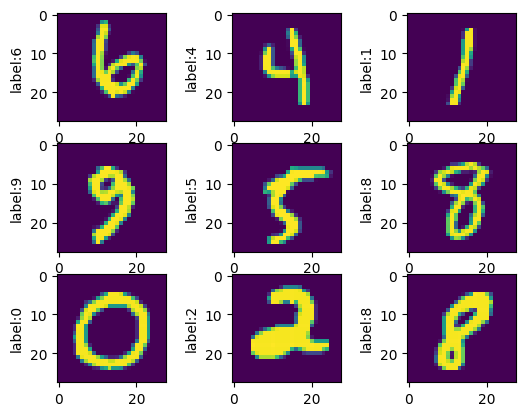

In [ ]:
plot_img(validation, val_predicted)

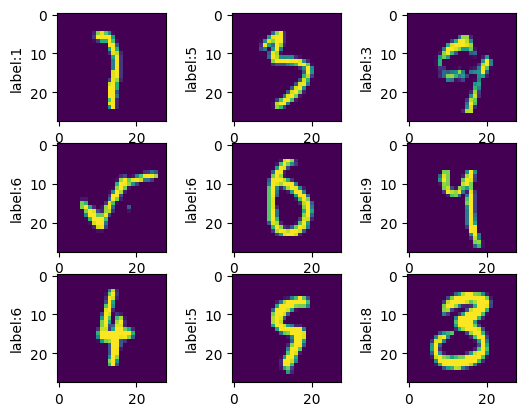

In [ ]:
# wrong predicted

val_wrong = validation[validation_label != val_predicted]
val_lab_wrong = val_predicted[validation_label != val_predicted]

plot_img(val_wrong, val_lab_wrong)

In [ ]:
torch.manual_seed(0)                                      # set seed to make results reproducible

batch_size = 128                                          # Set the batch_size
train_all_dataset = torch.utils.data.TensorDataset(train_all_tensor, train_all_label_tensor)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

epochs = 40                                               # set number of epohs

net = FNet()                                              # initialize network
criterion = nn.CrossEntropyLoss()                         # set criterion
optimizer = torch.optim.Adam(net.parameters(), lr = 3e-4) # set optimizer

                                                          # start training process
train_accuracies, train_losses = training(trainloader, epochs, net, criterion, optimizer)

Epoch: 1/40  Training Loss: 0.2921  Training accuracy: 91.6261
Epoch: 2/40  Training Loss: 0.0957  Training accuracy: 97.0057
Epoch: 3/40  Training Loss: 0.0508  Training accuracy: 98.3811
Epoch: 4/40  Training Loss: 0.0347  Training accuracy: 98.9039
Epoch: 5/40  Training Loss: 0.0290  Training accuracy: 99.0197
Epoch: 6/40  Training Loss: 0.0267  Training accuracy: 99.0702
Epoch: 7/40  Training Loss: 0.0278  Training accuracy: 99.0880
Epoch: 8/40  Training Loss: 0.0293  Training accuracy: 99.0583
Epoch: 9/40  Training Loss: 0.0155  Training accuracy: 99.4742
Epoch: 10/40  Training Loss: 0.0176  Training accuracy: 99.4089
Epoch: 11/40  Training Loss: 0.0218  Training accuracy: 99.3465
Epoch: 12/40  Training Loss: 0.0234  Training accuracy: 99.2663
Epoch: 13/40  Training Loss: 0.0197  Training accuracy: 99.4089
Epoch: 14/40  Training Loss: 0.0148  Training accuracy: 99.5604
Epoch: 15/40  Training Loss: 0.0137  Training accuracy: 99.5752
Epoch: 16/40  Training Loss: 0.0226  Training acc

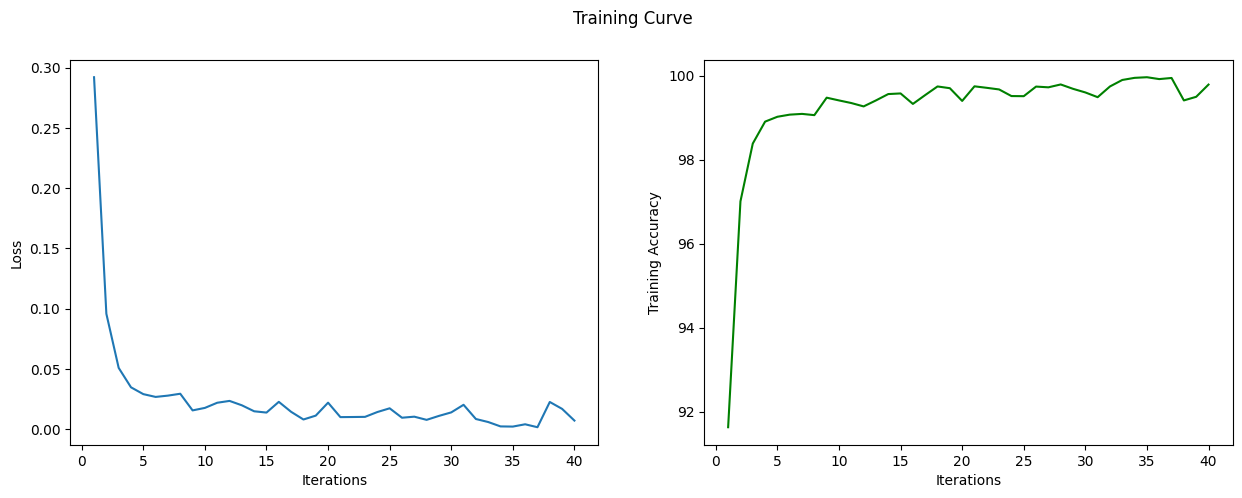

In [ ]:
train_curves(epochs, train_losses, train_accuracies)

In [ ]:
# set net in test (evaluation) mode
net.eval()

# get predictions for test data
test_predictions = net(test_tensor)

# to get class with the maximum score as prediction
_, test_predicted = torch.max(test_predictions.data,1)

# Save results in the required format
output = pd.DataFrame({'ImageId': test.index + 1,
                       'Label': test_predicted})
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
